# 6장

# 결정 트리 학습과 시각화

In [12]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "decision_trees"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [13]:
# 붓꽃 데이터셋에 DecisionTreeC;assofoer를 훈련 붓꽃 데이터셋에 DecisionTreeC;assofoer를 훈련
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris()
X = iris.data[:, 2:] # 꽃잎 길이와 너비
y = iris.target

tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(X, y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=2, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [14]:
# export_graghviz() 함수를 사용해 그래프 정의를 iris_tree.dot 파일로 출력
# 훈련된 결정 트리를 시각화 한다.

from sklearn.tree import export_graphviz

export_graphviz(
        tree_clf,
        out_file=os.path.join(IMAGES_PATH, "iris_tree.dot"),
        feature_names=iris.feature_names[2:],
        class_names=iris.target_names,
        rounded=True,
        filled=True
    )

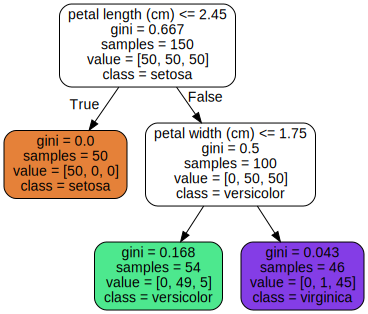

In [15]:
# 붓꽃 결정 트리
from graphviz import Source
Source.from_file(os.path.join(IMAGES_PATH, "iris_tree.dot"))

# 예측하기

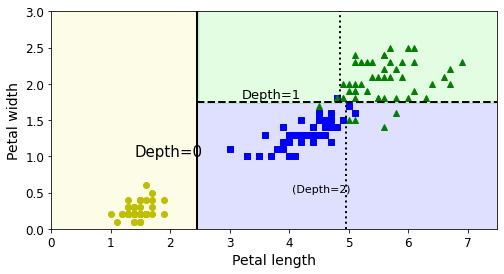

In [18]:
# 결정 트리의 결정 경계
# 굵은 수직선이 루트 노드(깊이=0)의 결정 경계(꽃잎 길이 = 2.45cm)
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[0, 7.5, 0, 3], iris=True, legend=False, plot_training=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if not iris:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    if plot_training:
        plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris setosa")
        plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris versicolor")
        plt.plot(X[:, 0][y==2], X[:, 1][y==2], "g^", label="Iris virginica")
        plt.axis(axes)
    if iris:
        plt.xlabel("Petal length", fontsize=14)
        plt.ylabel("Petal width", fontsize=14)
    else:
        plt.xlabel(r"$x_1$", fontsize=18)
        plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    if legend:
        plt.legend(loc="lower right", fontsize=14)

plt.figure(figsize=(8, 4))
plot_decision_boundary(tree_clf, X, y)
plt.plot([2.45, 2.45], [0, 3], "k-", linewidth=2)
plt.plot([2.45, 7.5], [1.75, 1.75], "k--", linewidth=2)
plt.plot([4.95, 4.95], [0, 1.75], "k:", linewidth=2)
plt.plot([4.85, 4.85], [1.75, 3], "k:", linewidth=2)
plt.text(1.40, 1.0, "Depth=0", fontsize=15)
plt.text(3.2, 1.80, "Depth=1", fontsize=13)
plt.text(4.05, 0.5, "(Depth=2)", fontsize=11)

plt.show()

# 클래스 확률 추정

<결정 트리는 한 샘플이 특정 클래스 k에 속할 확률 추정 >\
1. 샘플에 대한 리프 노드 찾기 위해 트리를 탐색
2. 그 노드에 있는 클래스 k의 훈련 샘플의 비율을 반환
3. 만약 클래스를 하나 예측한다면 가장 높은 확률을 가진 Iris-Versicolor(클래스1)를 출력

In [19]:
tree_clf.predict_proba([[5, 1.5]])

array([[0.        , 0.90740741, 0.09259259]])

In [20]:
tree_clf.predict([[5,1.5]])

array([1])

# CART 훈련 알고리즘

사이킷런은 결정 트리를 훈련시키기 위해(트리를 성장시키기 위해) CART 알고리즘을 사용한다.\
1. 훈련 세트를 하나의 특성 k의 임곗값을 사용해 두개의 서브셋으로 나눈다. (예, 꽃잎의 길이 <= 2.45cm)
2. 훈련세트를 성공적으로 둘로 나누었다면 같은 방식으로 서브셋을 계속 반복적으로 나눈다.
3. 최대 깊이(max_depth)가 되면 중지하거나 불순도를 줄이는 분할을 찾을 수 없을 때 멈춘다. 좋은 방법의 알고리즘이지만 무한적으로 계속 반복하다 보면 과대 적합 결과가 나온다.

# 계산 복잡도

* 일반적으로 결정 트리는 거의 균형을 이루고 있으므로 결정 트리를 탐색하기 위해서는 약 O(lg(m))개의 노드를 거쳐야 한다.
* 각 노드는 하나의 특성값만 확인하기 때문에 예측에 필요한 전체 복잡도는 특성 수와 무관하게 O(lg(m))이다.
* 그래서 큰 훈련 세트를 다룰 때도 예측 속도가 매우 빠르다.
\n

* 훈련 알고리즘은 각 노드에서 모든 훈련 샘플의 모든 특성을 비교한다.
* 각 노드에서 모든 샘플의 모든 특성을 비교하면 훈련 복잡도는 O(n X m lg(m))이 된다.
* 훈련 세트가 작을 경우 미리 데이터를 정렬하여 훈련속도를 높일 수 있다.
* 하지만 훈련세트가 클 경우 속도가 많이 느리다.

# 지니 불순도 또는 엔트로피?

기본적으로 지니 불순도가 사용되지만 criterion 매개변수를 "entropy"로 지정하여 엔트로피 불순도를 사용할 수 있다.\
엔트로피는 분자의 무질서함을 측정하는 것으로 분자가 안정되고 질서 정연하면 엔트로피가 0에 가깝다.\
DecisionTreeClassifier의 criterion 매개변수의 기본값은 "gini"이고, DecisionTreeRegressor의 기본값은 "mse"이다.\
지니 불순도와 엔트로피느 비슷한 트리를 만들어 낸다.\
그러나 다른 트리가 만들어지는 경우 지니 불순도가 가장 빈도 높은 클래스를 한쪽 가지로 고립시키는 경향이 있는 반면 엔트로피는 조금 더 균형 잡힌 트리를 만든다.

# 규제 매개변수

결정 트리는 훈련 데이터에 대한 제약 사항이 거의 없다
=> 제한을 두지 않으면 트리가 훈련 데이터에 아주 가깝게 맞추려고 해서 대부분 과대 적합되기 쉽다.

비파라미터 모델 : 훈련되기 전에 파라미터 수가 결정 되지 않는다.
모델 구조가 데이터에맞춰져서 공정되지 않고 자유롭다.\
파라미터 모델 :  반대로 선형모델 같은.
미리 정의된 모델 파라미터수를 가지므로 자유도가 제한되고 과대적합될 위험이 적다.(하지만 과소적합될 위험이 커진다.)

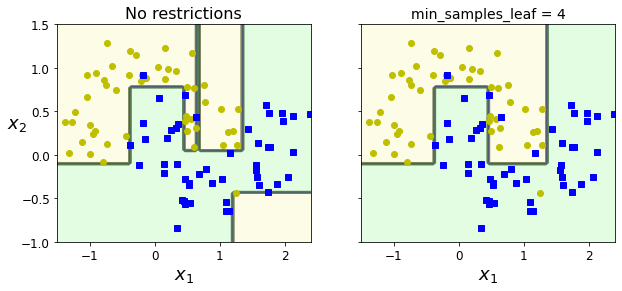

In [21]:

from sklearn.datasets import make_moons
Xm, ym = make_moons(n_samples=100, noise=0.25, random_state=53)

deep_tree_clf1 = DecisionTreeClassifier(random_state=42)
deep_tree_clf2 = DecisionTreeClassifier(min_samples_leaf=4, random_state=42)
deep_tree_clf1.fit(Xm, ym)
deep_tree_clf2.fit(Xm, ym)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(deep_tree_clf1, Xm, ym, axes=[-1.5, 2.4, -1, 1.5], iris=False)
plt.title("No restrictions", fontsize=16)
plt.sca(axes[1])
plot_decision_boundary(deep_tree_clf2, Xm, ym, axes=[-1.5, 2.4, -1, 1.5], iris=False)
plt.title("min_samples_leaf = {}".format(deep_tree_clf2.min_samples_leaf), fontsize=14)
plt.ylabel("")

plt.show()

# 회귀

In [23]:
'''
사이킷런의 DecisionTreeRegressor를 사용해 
잡음이 섞인 2차 함수 형태의 데이터셋에서
max_depth=2 설정으로 회귀 트리
'''
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(max_depth=2)
tree_reg.fit(X,y)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

그림 저장: tree_regression_plot


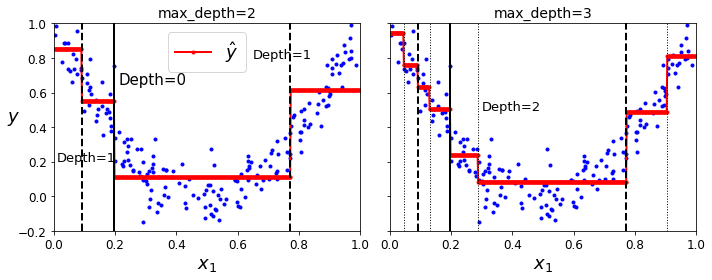

In [30]:
# 구 개의 결정 트리 회귀 모델의 예측 구 개의 결정 트리 회귀 모델의 예측
np.random.seed(42)
m = 200
X = np.random.rand(m, 1)
y = 4 * (X - 0.5) ** 2
y = y + np.random.randn(m, 1) / 10

from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(random_state=42, max_depth=2)

np.random.seed(42)
m = 200
X = np.random.rand(m, 1)
y = 4 * (X - 0.5) ** 2
y = y + np.random.randn(m, 1) / 10

from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(random_state=42, max_depth=2)
tree_reg2 = DecisionTreeRegressor(random_state=42, max_depth=3)
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)

def plot_regression_predictions(tree_reg, X, y, axes=[0, 1, -0.2, 1], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)
    plt.plot(X, y, "b.")
    plt.plot(x1, y_pred, "r.-", linewidth=2, label=r"$\hat{y}$")

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_regression_predictions(tree_reg1, X, y)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
plt.text(0.21, 0.65, "Depth=0", fontsize=15)
plt.text(0.01, 0.2, "Depth=1", fontsize=13)
plt.text(0.65, 0.8, "Depth=1", fontsize=13)
plt.legend(loc="upper center", fontsize=18)
plt.title("max_depth=2", fontsize=14)

plt.sca(axes[1])
plot_regression_predictions(tree_reg2, X, y, ylabel=None)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
for split in (0.0458, 0.1298, 0.2873, 0.9040):
    plt.plot([split, split], [-0.2, 1], "k:", linewidth=1)
plt.text(0.3, 0.5, "Depth=2", fontsize=13)
plt.title("max_depth=3", fontsize=14)

save_fig("tree_regression_plot")
plt.show()

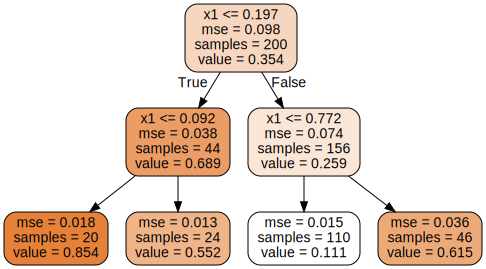

In [34]:
export_graphviz(
        tree_reg1,
        out_file=os.path.join(IMAGES_PATH, "regression_tree.dot"),
        feature_names=["x1"],
        rounded=True,
        filled=True
    )
# 회귀 결정 트리
Source.from_file(os.path.join(IMAGES_PATH, "regression_tree.dot"))

그림 저장: tree_regression_regularization_plot


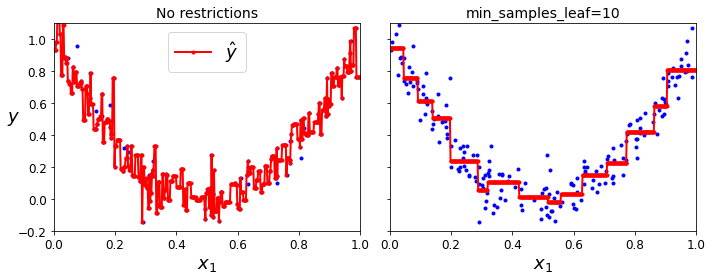

In [35]:
# 결정 트리 회귀 모델의 규제
tree_reg1 = DecisionTreeRegressor(random_state=42)
tree_reg2 = DecisionTreeRegressor(random_state=42, min_samples_leaf=10)
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)

x1 = np.linspace(0, 1, 500).reshape(-1, 1)
y_pred1 = tree_reg1.predict(x1)
y_pred2 = tree_reg2.predict(x1)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

plt.sca(axes[0])
plt.plot(X, y, "b.")
plt.plot(x1, y_pred1, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([0, 1, -0.2, 1.1])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", fontsize=18, rotation=0)
plt.legend(loc="upper center", fontsize=18)
plt.title("No restrictions", fontsize=14)

plt.sca(axes[1])
plt.plot(X, y, "b.")
plt.plot(x1, y_pred2, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([0, 1, -0.2, 1.1])
plt.xlabel("$x_1$", fontsize=18)
plt.title("min_samples_leaf={}".format(tree_reg2.min_samples_leaf), fontsize=14)

save_fig("tree_regression_regularization_plot")
plt.show()

# 불안정성

* 결정 트리의 장점
1. 이해하고 해석하기 쉽다.
2. 사용하기 편하고 여러 용도로 사용할 수 있으며 성능도 뛰어나다.
* 결정 트리의 단점
1. 결정 트리는 계단 모양의 결정 경계를 만든다.(모든 분할은 축에 수직이다.)\
=> 훈련 세트의 회전에 민감하다.\
해결하는 한가지 방법은 훈련 데이터를 더 좋은 방향으로 회전시키는 PCA 기법을 사용한다.

그림 저장: sensitivity_to_rotation_plot


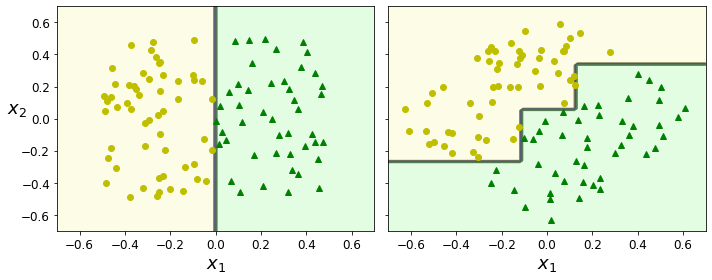

In [36]:
# 훈련세트의 회전에 민감한 결정 트리
# 왼쪽의 결정 트리는 쉽게 데이터셋을 구분
# 오른쪽(데이터셋을 45도 회전)의 결정 트리는 불필요하게 구불구불해졌다.
np.random.seed(6)
Xs = np.random.rand(100, 2) - 0.5
ys = (Xs[:, 0] > 0).astype(np.float32) * 2

angle = np.pi / 4
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
Xsr = Xs.dot(rotation_matrix)

tree_clf_s = DecisionTreeClassifier(random_state=42)
tree_clf_s.fit(Xs, ys)
tree_clf_sr = DecisionTreeClassifier(random_state=42)
tree_clf_sr.fit(Xsr, ys)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf_s, Xs, ys, axes=[-0.7, 0.7, -0.7, 0.7], iris=False)
plt.sca(axes[1])
plot_decision_boundary(tree_clf_sr, Xsr, ys, axes=[-0.7, 0.7, -0.7, 0.7], iris=False)
plt.ylabel("")

save_fig("sensitivity_to_rotation_plot")
plt.show()